## Examining and processing MPC dataset 

In [58]:
## the data are files inside the MPC CORPUS/chat_sessions_annotated
import os

def get_files():
    files = []
    for root, dirs, file in os.walk("MPC CORPUS/chat_sessions_annotated"):
        for f in file:
            files.append(os.path.join(root, f))
    return files

files=get_files()

In [59]:
## read xml files, each line is a message with annotations tags
import xml.etree.ElementTree as ET

def read_file(file):
    tree = ET.parse(file)
    convo = file.replace(".xml","")
    root = tree.getroot()
    messages = []
    for message in root.findall('turn'):
        # turn it into a dictionary of text and annotations (annotations are inside attributes)
        message_dict = {}
        # attributes
        for key, value in message.items():
            message_dict[key] = value
        # text
        message_dict['text'] = message.text
        message_dict['session'] = convo
        messages.append(message_dict)


        
    return messages

messages = []
for file in files:
    messages += read_file(file)

In [60]:
# load messages into a pandas dataframe
import pandas as pd

df = pd.DataFrame(messages)

In [61]:
df.head()

,comm_act_type,dialog_act,end_time,link_to,mode,polarity,pos,pos_count,pos_origin,speaker,topic,turn_no,text,session,start_time
0,response-to,COMM-MGMT:Other-Conventional-Phrase,09:24:25 AM,,chat,,,,,moderator,,1,link,MPC CORPUS/chat_sessions_annotated/Mar14_Group...,NaN
1,addressed-to,COMM-MGMT:Assertion-Opinion,10:01:12 AM,all-users,chat,,,1,;topic(2.1),cintihia,,2,cool topic,MPC CORPUS/chat_sessions_annotated/Mar14_Group...,NaN
2,addressed-to,COMM-MGMT:Conventional-Opening,10:01:41 AM,all-users,chat,,,1,;people(3.1),moderator,,3,:-) thanks....good morning...just waiting for ...,MPC CORPUS/chat_sessions_annotated/Mar14_Group...,NaN
3,addressed-to,COMM-MGMT:Acknowledge,10:01:50 AM,all-users,chat,,,,,ted,,4,ok,MPC CORPUS/chat_sessions_annotated/Mar14_Group...,NaN
4,addressed-to,COMM-MGMT:Conventional-Opening,10:05:07 AM,all-users,chat,,,,,ariel,,5,hi,MPC CORPUS/chat_sessions_annotated/Mar14_Group...,NaN


In [62]:
# see what lines are missing dialog acts
(df["dialog_act"]=="").sum()

753

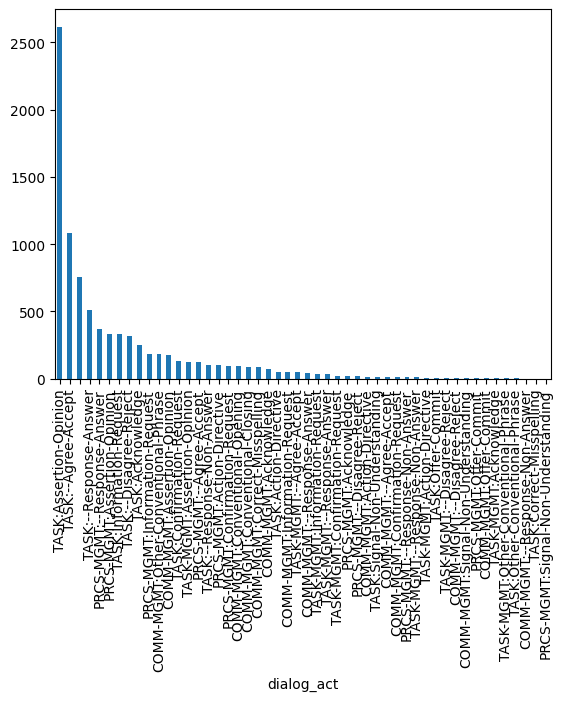

In [63]:
# plot the distribution of dialog acts
import matplotlib.pyplot as plt
df["dialog_act"].value_counts().plot(kind='bar')
plt.show()

<Axes: xlabel='session'>

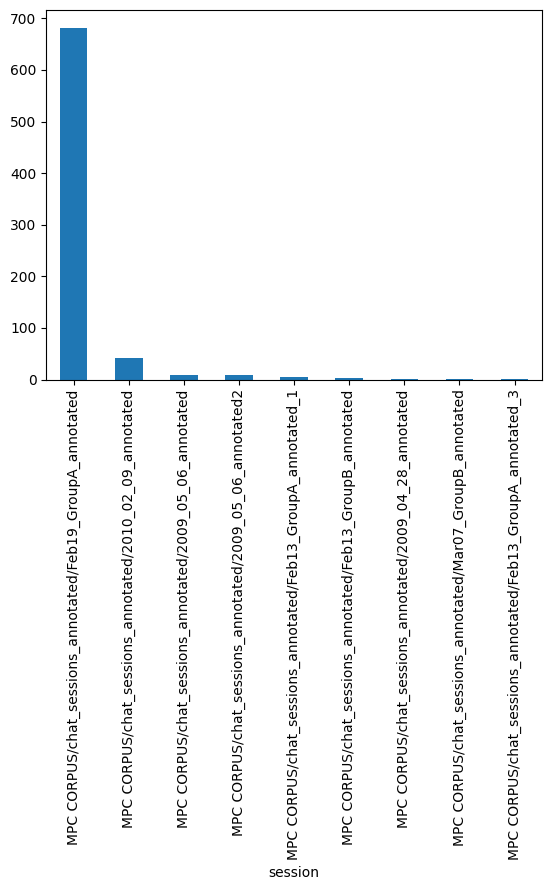

In [64]:
## plot the session of messages without dialog acts
df[df.dialog_act==""]["session"].value_counts().plot(kind='bar')

In [65]:
## drop them
df = df[df.dialog_act!=""]

In [66]:
# save the dataframe to jsons
df.to_json("MPC_CORPUS.jsonl", orient='records', lines=True)

## Let's examinate dialogue acts

In [67]:
df["dialog_act"].value_counts()

dialog_act
TASK:Assertion-Opinion                 2617
TASK:--Agree-Accept                    1080
TASK:--Response-Answer                  513
PRCS-MGMT:--Response-Answer             373
PRCS-MGMT:Assertion-Opinion             333
TASK:Information-Request                329
TASK:--Disagree-Reject                  314
TASK:Acknowledge                        254
PRCS-MGMT:Information-Request           187
COMM-MGMT:Other-Conventional-Phrase     187
COMM-MGMT:Assertion-Opinion             176
TASK:Confirmation-Request               132
TASK-MGMT:Assertion-Opinion             127
PRCS-MGMT:--Agree-Accept                126
TASK:--Response-Non-Answer              102
PRCS-MGMT:Action-Directive               99
PRCS-MGMT:Confirmation-Request           93
COMM-MGMT:Conventional-Opening           92
COMM-MGMT:Conventional-Closing           90
COMM-MGMT:Correct-Misspelling            85
COMM-MGMT:Acknowledge                    72
TASK:Action-Directive                    50
COMM-MGMT:Information

<Axes: >

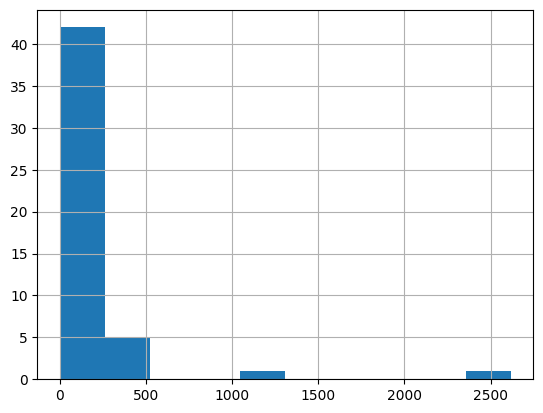

In [68]:
df["dialog_act"].value_counts().hist(bins=10)

In [69]:
df.dialog_act.nunique()

49

In [70]:
## let's divide them by prefix

dialog_acts = df["dialog_act"].str.split(":", expand=True)  

In [71]:
dialog_acts.columns = ["prefix", "dialog_act"]

In [72]:
dialog_acts["prefix"].value_counts()

prefix
TASK         5418
PRCS-MGMT    1265
COMM-MGMT     852
TASK-MGMT     299
Name: count, dtype: int64

In [73]:
# let's see unique dialog acts by prefix

dialog_acts.groupby("prefix")["dialog_act"].nunique()

prefix
COMM-MGMT    15
PRCS-MGMT    11
TASK         13
TASK-MGMT    10
Name: dialog_act, dtype: int64

In [74]:
dialog_acts["dialog_act"].nunique()

15

In [75]:
## ok, so disregarding the prefix, we have 15 unique dialog acts

dialog_acts["dialog_act"].value_counts()

dialog_act
Assertion-Opinion            3253
--Agree-Accept               1267
--Response-Answer             967
Information-Request           602
Acknowledge                   350
--Disagree-Reject             346
Confirmation-Request          260
Other-Conventional-Phrase     191
Action-Directive              173
--Response-Non-Answer         122
Conventional-Opening           92
Conventional-Closing           90
Correct-Misspelling            86
Signal-Non-Understanding       21
Offer-Commit                   14
Name: count, dtype: int64

In [76]:
# let's create a sub df with only speaker, text and dialog_act with no prefix

conv_df= pd.concat([df[["speaker", "text"]], dialog_acts["dialog_act"]], axis=1)

In [78]:
conv_df

,speaker,text,dialog_act
0,moderator,link,Other-Conventional-Phrase
1,cintihia,cool topic,Assertion-Opinion
2,moderator,:-) thanks....good morning...just waiting for ...,Conventional-Opening
3,ted,ok,Acknowledge
4,ariel,hi,Conventional-Opening
...,...,...,...
7900,lynn,"i have to admit, i didn't really consider that...",--Agree-Accept
7901,macy,for something so special like a national event...,Assertion-Opinion
7902,lynn,that's true,--Agree-Accept
7903,melany,yes true,--Agree-Accept


In [97]:
## save that

conv_df.to_json("mpc_messages.jsonl", orient='records', lines=True)

## Let's try to use this for few-shot learning

In [82]:
## dialogue acts unique

dialog_acts["dialog_act"].value_counts().index

Index(['Assertion-Opinion', '--Agree-Accept', '--Response-Answer',
       'Information-Request', 'Acknowledge', '--Disagree-Reject',
       'Confirmation-Request', 'Other-Conventional-Phrase', 'Action-Directive',
       '--Response-Non-Answer', 'Conventional-Opening', 'Conventional-Closing',
       'Correct-Misspelling', 'Signal-Non-Understanding', 'Offer-Commit'],
      dtype='object', name='dialog_act')

In [95]:
## get some consecutive messages with dialog acts

import random

starting_point = random.randint(0, len(conv_df))

for i in range(50):
    print(conv_df.iloc[starting_point+i]["speaker"],":", conv_df.iloc[starting_point+i]["text"],"(", conv_df.iloc[starting_point+i]["dialog_act"],")")


rita : They had insentives were you could get paid to take it ( Assertion-Opinion )
lynn : this is a mixture of what some people said before ( Information-Request )
david : ny is really the only true exception ( Assertion-Opinion )
lynn : although the water and highway might be switched based on what was just said ( Information-Request )
rita : You mean NYC ( Information-Request )
meg : no, there's a whole rail system in san francisco ( --Disagree-Reject )
rita : or NY ( Information-Request )
david : no New York ( --Response-Answer )
lynn : chicago too ( Assertion-Opinion )
rita : I live in Cortland ( Assertion-Opinion )
david : a lot of people refer to it just simply as New York ( --Response-Answer )
rita : and there is no public transportation ( Assertion-Opinion )
rita : There are short buses for the disables and that is it ( Assertion-Opinion )
david : NYC is like if you're going to differentiate b/n upstate and downstate, but upstate is not really that important in comparison ( --

In [96]:
df.shape

(7834, 15)